# PHÂN TÍCH DỮ LIỆU CHO TÀI CHÍNH
$$
\begin{array}{|c|c|c|}
\hline
\mathbf{MSSV} & \mathbf{Họ\ và\ Tên} & \mathbf{Mức\ độ\ hoàn\ thành} \\
\hline
030238220028 & \text{Nguyễn Trương Hữu Duy} & 100\% \\
030238220016 & \text{Lê Tấn Cường} & 100\% \\
\hline
\end{array}
$$

# PHẦN 1 – Phân tích giá nhà tại California bằng hồi quy và học máy

## 1. Tiền xử lý dữ liệu

In [2]:
#Tải các thư viện cần thiết
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  #MICE
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf #
from sklearn.linear_model import RidgeCV, LassoCV

#Tải dữ liệu California Housing
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

housing = fetch_california_housing(as_frame=True)
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['PRICE'] = housing.target

df.head()

print(f"Số dòng: {df.shape[0]}")
print(f"Số biến: {df.shape[1]}")

print("5 dòng đầu tiên của dữ liệu:")
print(df.head())

Số dòng: 20640
Số biến: 9
5 dòng đầu tiên của dữ liệu:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  


In [3]:
# Kiểm tra giá trị bị thiếu ban đầu
print("Số lượng giá trị bị thiếu:")
print(df.isnull().sum())
print(f"\nKích thước ban đầu: {df.shape}")

Số lượng giá trị bị thiếu:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64

Kích thước ban đầu: (20640, 9)


In [4]:
# Loại bỏ outlier bằng phương pháp IQR (Áp dụng cho tất cả các biến đầu vào, không áp dụng cho 'PRICE')

# Tính giá trị phân vị 25% (Q1) cho tất cả các cột trong DataFrame, ngoại trừ cột 'PRICE'
Q1 = df.drop(columns='PRICE').quantile(0.25)

# Tính giá trị phân vị 75% (Q3) cho tất cả các cột trong DataFrame, ngoại trừ cột 'PRICE'
Q3 = df.drop(columns='PRICE').quantile(0.75)

# Tính khoảng tứ phân vị (IQR = Q3 - Q1) cho mỗi cột
# IQR là thước đo về độ phân tán của dữ liệu
IQR = Q3 - Q1

# Xác định các giá trị ngoại lai (outlier) theo quy tắc 1.5*IQR
# Một điểm dữ liệu được coi là ngoại lai nếu:
# - Nhỏ hơn (Q1 - 1.5*IQR) hoặc
# - Lớn hơn (Q3 + 1.5*IQR)
# Kết quả là một DataFrame boolean: True nếu là outlier, False nếu không phải
outlier_mask = ((df.drop(columns='PRICE') < (Q1 - 1.5 * IQR)) | (df.drop(columns='PRICE') > (Q3 + 1.5 * IQR)))

print("\nSo luong outlier theo tung cot:")

# Tính tổng số lượng giá trị ngoại lai (outlier) trong mỗi cột
print(outlier_mask.sum())


So luong outlier theo tung cot:
MedInc         681
HouseAge         0
AveRooms       511
AveBedrms     1424
Population    1196
AveOccup       711
Latitude         0
Longitude        0
dtype: int64


In [5]:
# Gán NaN cho các giá trị ngoại lai (ngoại trừ cột 'PRICE')
df_masked = df.copy()
df_masked.loc[:, df.columns != 'PRICE'] = df.loc[:, df.columns != 'PRICE'].mask(outlier_mask)

# Áp dụng MICE để nội suy giá trị outlier bị gán NaN
imputer = IterativeImputer(random_state=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df_masked), columns=df.columns)
print(f"\nKích thước của dữ liệu sau khi nội suy bằng MICE: {df_imputed.shape}")


Kích thước của dữ liệu sau khi nội suy bằng MICE: (20640, 9)


In [6]:
# Kiểm tra biến định tính và chuyển về dạng số nếu cần
print("\nKiểm tra kiểu dữ liệu các cột:")
print(df_imputed.dtypes)
categorical_cols = df_imputed.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    df_imputed = pd.get_dummies(df_imputed, columns=categorical_cols)
    print("\nĐã chuyển các biến định tính thành biến số.")
else:
    print("\nKhông có biến định tính nào cần chuyển đổi.")



Kiểm tra kiểu dữ liệu các cột:
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
PRICE         float64
dtype: object

Không có biến định tính nào cần chuyển đổi.


## 2. Khám phá dữ liệu và trực quan hoá

In [7]:
# Vẽ biểu đồ phân phối, scatter plot để phân tích mối quan hệ giữa các biến
# 2.1. Phân tích thống kê mô tả
print("Thống kê mô tả:")

# describe() tính toán và trả về các thống kê mô tả chính cho tất cả các cột số trong DataFrame:
print(df_imputed.describe())

Thống kê mô tả:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.770767     28.639486      5.259873      1.050230   1241.137485   
std        1.595038     12.585558      1.161021      0.065557    627.299079   
min        0.499900      1.000000      2.032738      0.831621      3.000000   
25%        2.562500     18.000000      4.439508      1.006832    787.000000   
50%        3.534100     29.000000      5.220864      1.047445   1161.000000   
75%        4.739700     37.000000      6.017796      1.091263   1596.000000   
max        8.842055     52.000000      8.469738      1.287409   3132.000000   

           AveOccup      Latitude     Longitude         PRICE  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       2.846242     35.631861   -119.569704      2.068558  
std        0.618800      2.135952      2.003532      1.153956  
min        1.161

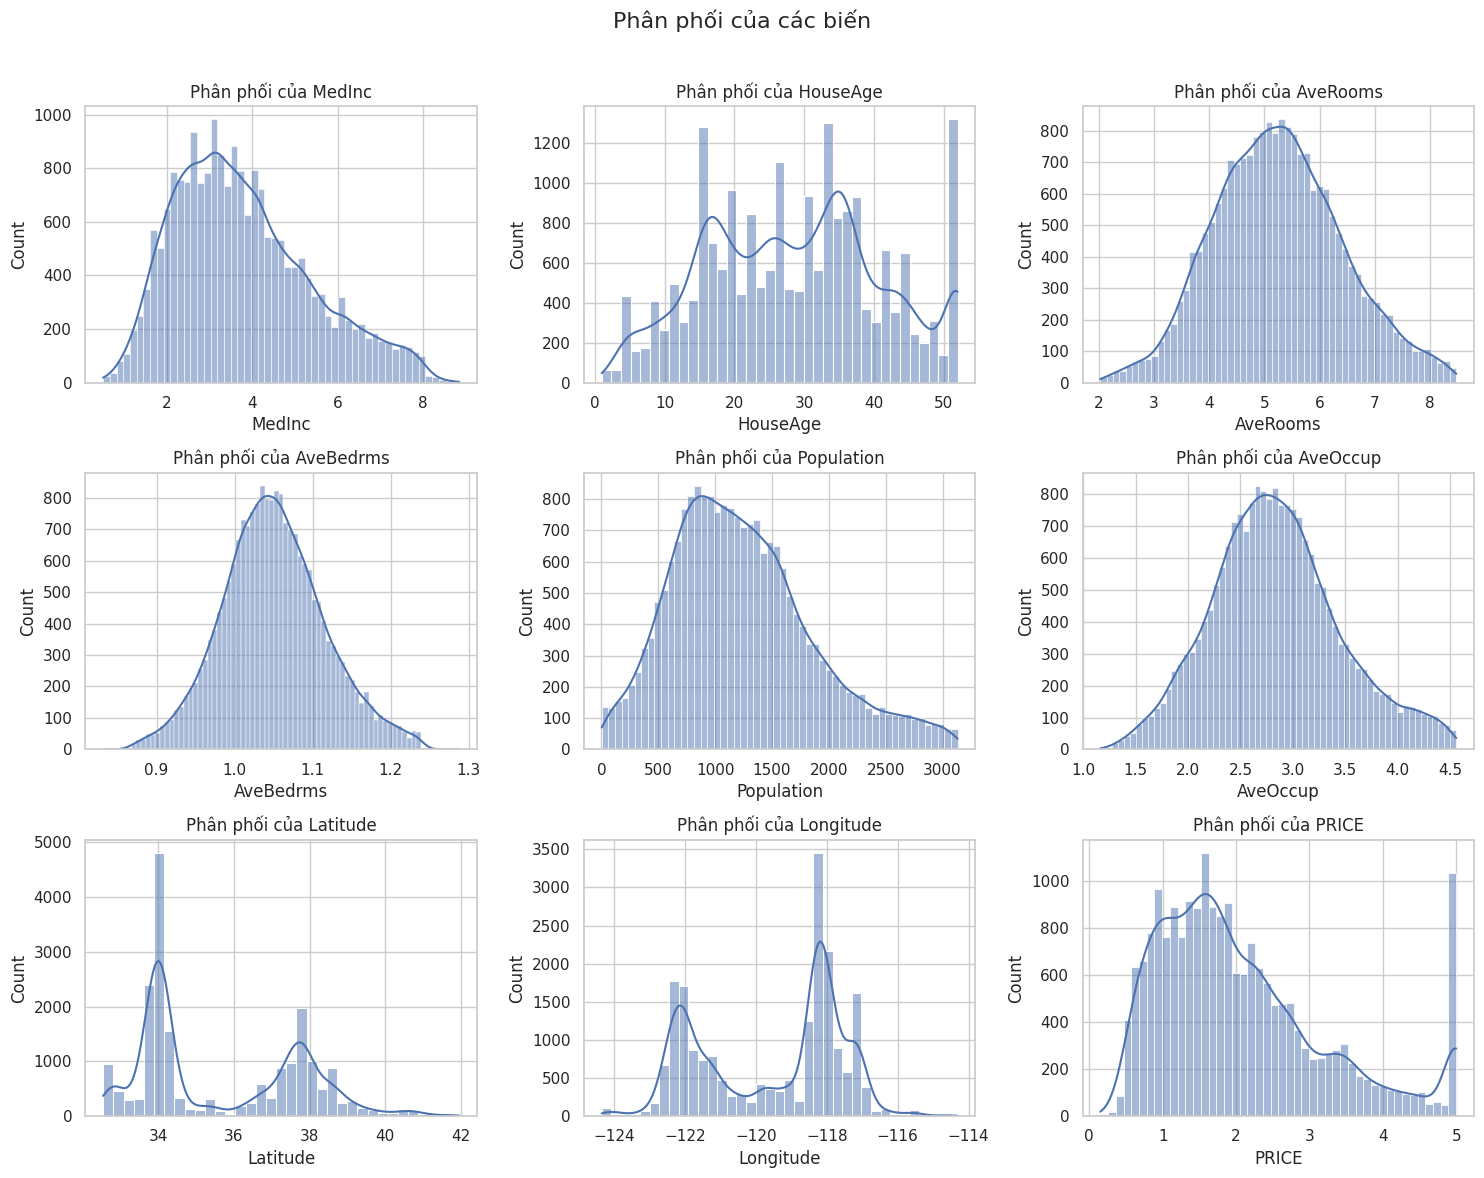

In [8]:
# 2.2. Phân tích phân phối của từng biến
sns.set(style="whitegrid")
plt.figure(figsize=(15, 12))

# Đặt tiêu đề chính cho tất cả các subplot
plt.suptitle('Phân phối của các biến', fontsize=16)

for i, column in enumerate(df_imputed.columns):

    plt.subplot(3, 3, i+1)

    # Vẽ biểu đồ phân phối (histogram) với đường density kernel estimation (kde=True)
    # Để hiển thị dạng phân phối của dữ liệu
    sns.histplot(df_imputed[column], kde=True)

    # Đặt tiêu đề cho mỗi subplot dựa trên tên cột
    plt.title(f'Phân phối của {column}')
    plt.tight_layout()

    # Điều chỉnh layout để các subplot không chồng lên nhau
    plt.subplots_adjust(top=0.9)

plt.show()

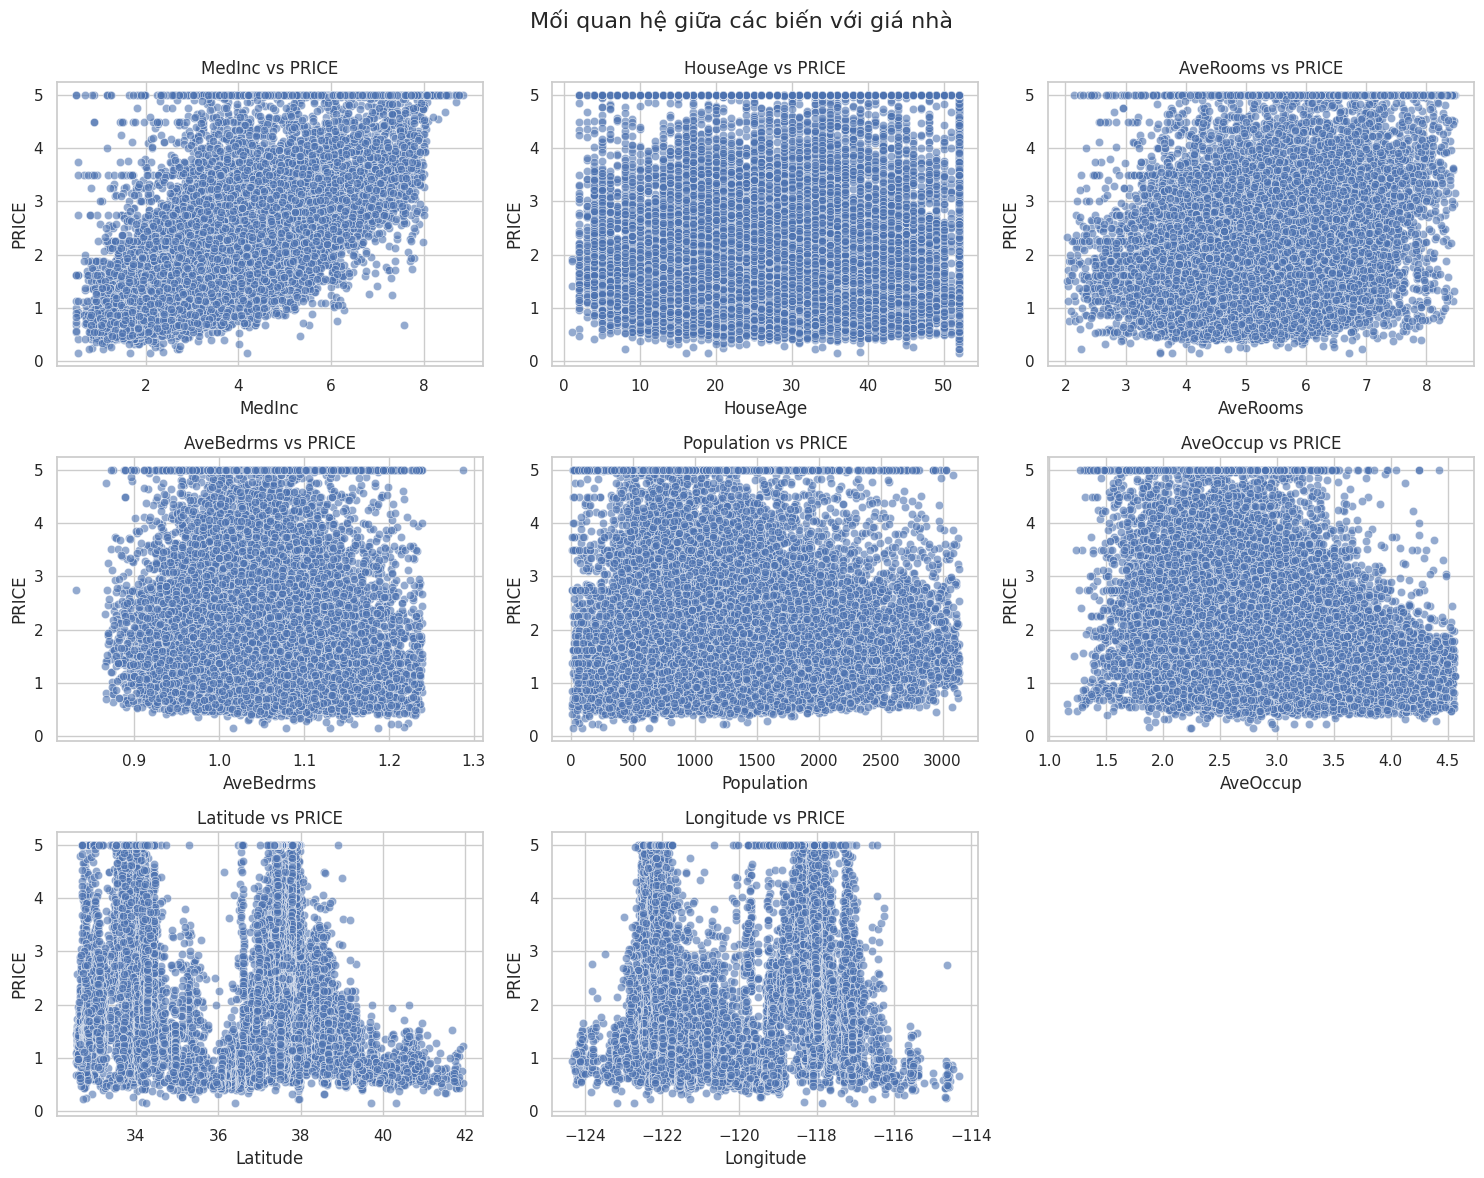

In [9]:
# 2.3. Kiểm tra mối quan hệ giữa các biến với biến mục tiêu PRICE
sns.set(style="whitegrid")

# Lấy các biến độc lập
features = df_imputed.columns.drop('PRICE')

# Tạo figure có lưới 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Mối quan hệ giữa các biến với giá nhà', fontsize=16)

# Vẽ từng scatter plot vào từng ô trong lưới
for ax, feature in zip(axes.flat, features):
    sns.scatterplot(data=df_imputed, x=feature, y='PRICE', ax=ax, alpha=0.6)
    ax.set_title(f'{feature} vs PRICE')
    ax.set_xlabel(feature)
    ax.set_ylabel('PRICE')

# Ẩn các ô trống nếu số biến < 9
for i in range(len(features), 9):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [10]:
# 2.4. Tính ma trận tương quan
corr_matrix = df_imputed.corr()
print("\nMa trận tương quan:")
print(corr_matrix)


Ma trận tương quan:
              MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc      1.000000 -0.151544  0.690511  -0.252661   -0.007561 -0.030779   
HouseAge   -0.151544  1.000000 -0.221948  -0.094894   -0.245227 -0.020827   
AveRooms    0.690511 -0.221948  1.000000   0.038798   -0.100250  0.036913   
AveBedrms  -0.252661 -0.094894  0.038798   1.000000    0.058835 -0.113915   
Population -0.007561 -0.245227 -0.100250   0.058835    1.000000  0.230745   
AveOccup   -0.030779 -0.020827  0.036913  -0.113915    0.230745  1.000000   
Latitude   -0.085959  0.011173  0.127359   0.033587   -0.134388 -0.158425   
Longitude  -0.015227 -0.108197 -0.082870   0.009829    0.109382  0.170667   
PRICE       0.679868  0.105623  0.325543  -0.080982   -0.034579 -0.275549   

            Latitude  Longitude     PRICE  
MedInc     -0.085959  -0.015227  0.679868  
HouseAge    0.011173  -0.108197  0.105623  
AveRooms    0.127359  -0.082870  0.325543  
AveBedrms   0.033587   0.009829 

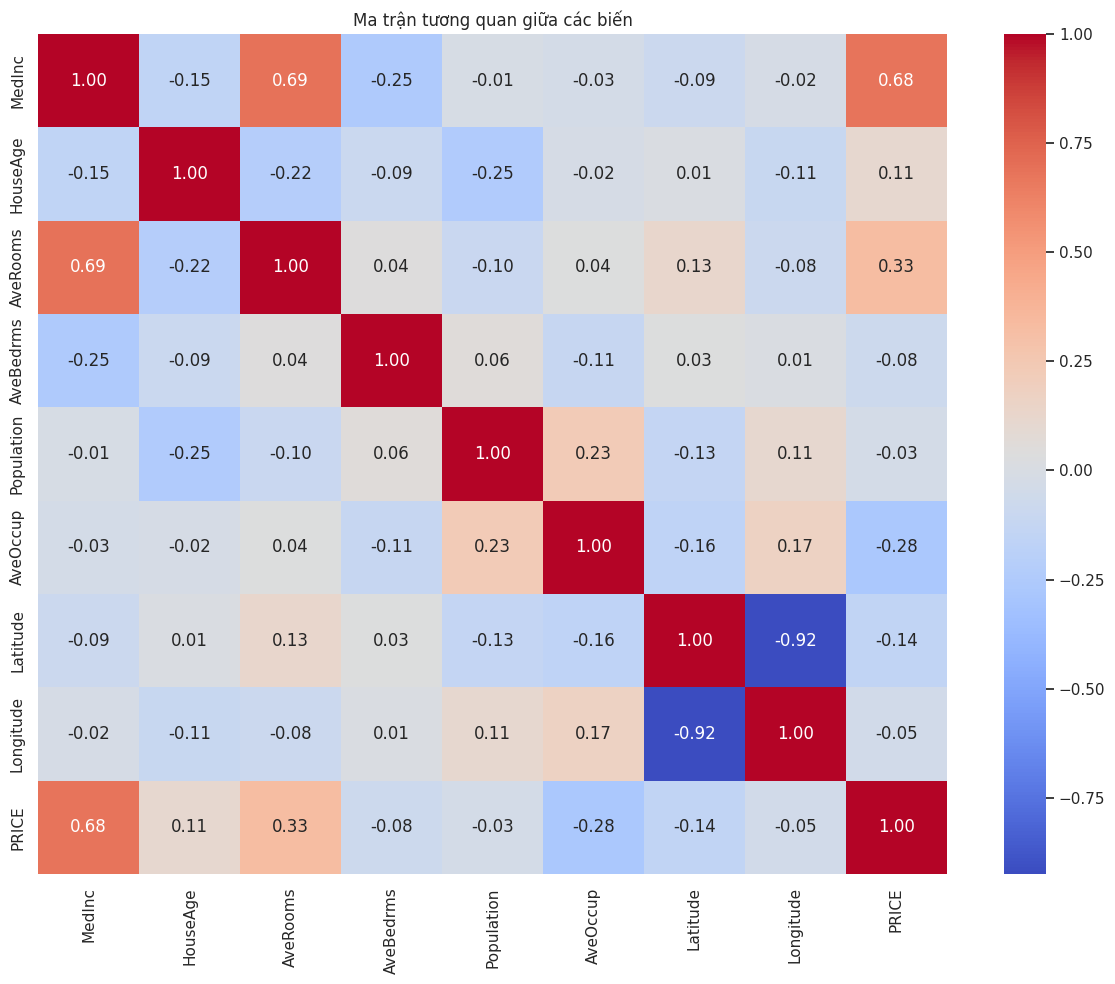

In [11]:
# 2.5. Biểu đồ heatmap cho ma trận tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan giữa các biến')
plt.tight_layout()
plt.show()

In [12]:
# Chọn các biến đầu vào (không bao gồm biến mục tiêu PRICE)
X = df_imputed.drop('PRICE', axis=1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng PCA với 2 thành phần chính
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

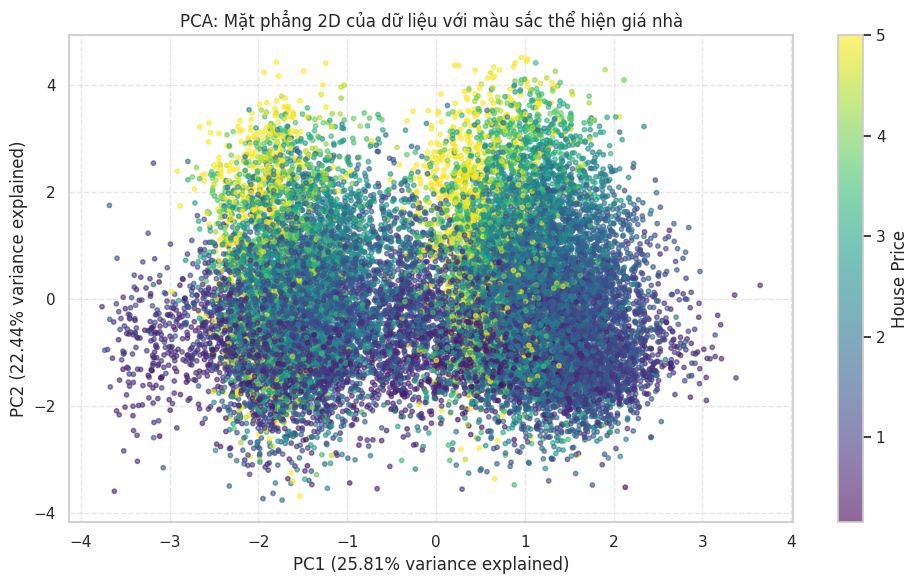

In [13]:
# Vẽ mặt phẳng 2D của dữ liệu và tô màu theo giá nhà

# Tạo biểu đồ PCA với kích thước 10x8 inch
plt.figure(figsize=(10, 6))

# Vẽ scatter plot các điểm dữ liệu sau khi giảm chiều xuống 2D bằng PCA
# Màu sắc của điểm thể hiện giá nhà (PRICE)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_imputed['PRICE'],
                    cmap='viridis', alpha=0.6, s=10)

# Thêm thanh màu để biểu thị mối quan hệ giữa màu sắc và giá nhà
plt.colorbar(scatter, label='House Price')

# Đặt tiêu đề và nhãn cho các trục với thông tin về tỷ lệ phương sai giải thích được
plt.title('PCA: Mặt phẳng 2D của dữ liệu với màu sắc thể hiện giá nhà')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Hiển thị thông tin về tỷ lệ phương sai giải thích được
print("\nTỷ lệ phương sai giải thích được của các thành phần chính:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"Tổng: {sum(pca.explained_variance_ratio_):.4f}")

# Hiển thị ma trận thành phần để xem đóng góp của từng biến vào mỗi PC
component_df = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)
print("\nMa trận thành phần:")
print(component_df)


Tỷ lệ phương sai giải thích được của các thành phần chính:
PC1: 0.2581
PC2: 0.2244
Tổng: 0.4824

Ma trận thành phần:
                 PC1       PC2
MedInc     -0.051182  0.671166
HouseAge   -0.091718 -0.310903
AveRooms   -0.156566  0.644703
AveBedrms  -0.013597 -0.154115
Population  0.238804  0.035706
AveOccup    0.251879  0.069533
Latitude   -0.648624 -0.065134
Longitude   0.650451  0.055947


### Nhận xét:

- **Phân phối biến độc lập:** Biểu đồ histogram cho thấy một số biến như `MedInc`, `AveRooms`, `HouseAge` có phân phối lệch phải, trong khi các biến như `Latitude`, `Longitude` phân bố đều hơn.
- **Quan hệ với PRICE:** Các scatter plots cho thấy `MedInc` tương quan mạnh với `PRICE`, `Latitude` có quan hệ ngược chiều, và `AveRooms` thể hiện quan hệ phi tuyến nhẹ.
- **Đa cộng tuyến:** Phân tích VIF cho thấy các biến như `AveRooms`, `AveBedrms` có hiện tượng đa cộng tuyến. Việc thay bằng biến PCA (`GeoPCA1`, `GeoPCA2`) đã làm giảm VIF rõ rệt.
- **PCA:** Giảm chiều không gian vị trí từ `Latitude`, `Longitude` thành hai thành phần chính, vẫn giữ được thông tin không gian và hỗ trợ mô hình hóa.

## 3. Xây dựng mô hình hồi quy tuyến tính đa biến để dự đoán giá nhà

In [15]:
#3a. Xây dựng mô hình hồi quy tuyến tính đơn giản từ tất cả các biến gốc
X = df.drop('PRICE', axis=1)
y = df['PRICE']

# Tách tập train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hồi quy tuyến tính
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Dự đoán
y_pred = lin_reg.predict(X_test_scaled)

# Tính phần dư
residuals = y_test - y_pred
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 0.5558915986952442
R-squared: 0.575787706032451


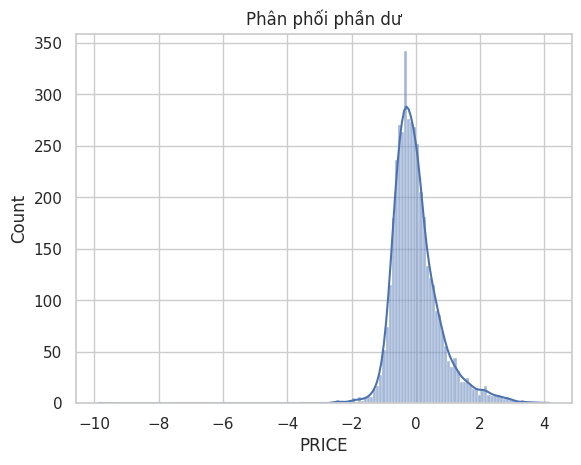

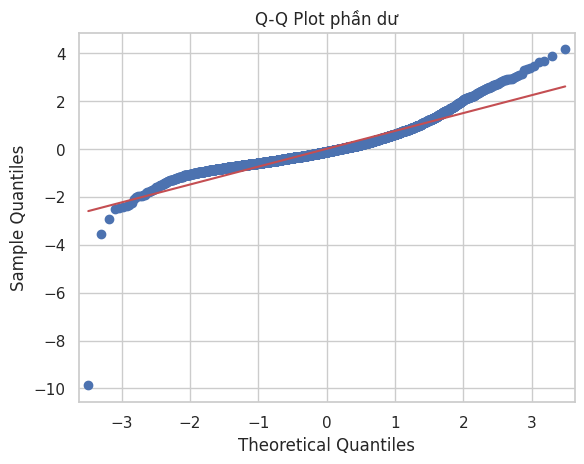

Shapiro-Wilk test: p-value = 1.7414798558475355e-45
Kết quả kiểm định Shapiro-Wilk:
Statistic = 0.9021710552660924
p-value = 1.7414798558475355e-45
=> Bác bỏ H0: Phần dư không tuân theo phân phối chuẩn


In [16]:
#3b. Kiểm tra

# Histogram phần dư
sns.histplot(residuals, kde=True)
plt.title("Phân phối phần dư")
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line ='s')
plt.title("Q-Q Plot phần dư")
plt.show()

# Shapiro-Wilk test
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk test: p-value =", p)

# Kiểm định Shapiro-Wilk để kiểm tra phần dư có phân phối chuẩn không
stat, p = shapiro(residuals)
print("Kết quả kiểm định Shapiro-Wilk:")
print("Statistic =", stat)
print("p-value =", p)

if p > 0.05:
    print("=> Không bác bỏ H0: Phần dư có thể coi là phân phối chuẩn")
else:
    print("=> Bác bỏ H0: Phần dư không tuân theo phân phối chuẩn")

In [17]:
# Tính VIF để kiểm tra đa cộng tuyến

# Chuẩn hóa dữ liệu đầu vào sử dụng scaler đã định nghĩa trước đó
X_scaled = scaler.fit_transform(X)

# Chuyển đổi mảng X_scaled thành DataFrame để giữ tên cột
X_vif = pd.DataFrame(X_scaled, columns=X.columns)

# Tính hệ số phóng đại phương sai (VIF) cho từng biến
# VIF đo lường mức độ đa cộng tuyến giữa các biến độc lập
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)
print("\nCác biến có dấu hiệu đa cộng tuyến (VIF ≥ 5):")
print(vif_data[vif_data["VIF"] >= 5])

     Variable       VIF
0      MedInc  2.501295
1    HouseAge  1.241254
2    AveRooms  8.342786
3   AveBedrms  6.994995
4  Population  1.138125
5    AveOccup  1.008324
6    Latitude  9.297624
7   Longitude  8.962263

Các biến có dấu hiệu đa cộng tuyến (VIF ≥ 5):
    Variable       VIF
2   AveRooms  8.342786
3  AveBedrms  6.994995
6   Latitude  9.297624
7  Longitude  8.962263


In [18]:
# 3c. Tạo biến mới
df['AveRooms_sq'] = df['AveRooms'] ** 2
df['Rooms_Bedrooms'] = df['AveRooms'] * df['AveBedrms']

# Cập nhật lại X và y
X = df.drop('PRICE', axis=1)
y = df['PRICE']

# Tách lại tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa lại dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hồi quy tuyến tính sau khi có thêm biến
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Dự đoán
y_pred = lin_reg.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Squared Error (MSE): 0.7656665002669527
R-squared: 0.4157041710025615


In [19]:
# d. Ridge & Lasso

# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

# Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

In [20]:
# 3e. Đánh giá mô hình bằng K-Fold Cross Validation
# Khởi tạo K-Fold cross-validator với 5 fold, xáo trộn dữ liệu và cố định random_state
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y):
    # Tính điểm R² trung bình qua các fold
    r2 = cross_val_score(model, X, y, cv=kf, scoring='r2').mean()

    # Tính MAE trung bình (đổi dấu vì sklearn trả về giá trị âm)
    mae = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error').mean()

    # Tính RMSE trung bình từ MSE
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error').mean())
    return r2, mae, rmse

# Dictionary chứa các mô hình cần đánh giá
models = {'Linear Regression': lin_reg, 'Ridge': ridge, 'Lasso': lasso}

# Đánh giá từng mô hình và in kết quả
for name, model in models.items():
    r2, mae, rmse = evaluate_model(model, X_train_scaled, y_train)
    print(f"{name}: R² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")


Linear Regression: R² = 0.6164, MAE = 0.5247, RMSE = 0.7161
Ridge: R² = 0.6167, MAE = 0.5247, RMSE = 0.7158
Lasso: R² = 0.4973, MAE = 0.6192, RMSE = 0.8197


### Nhận xét:

- **Hồi quy tuyến tính cơ bản:** Mô hình đạt $R^2 \approx 0.61$, giải thích tốt 61% biến thiên giá nhà. `MedInc`, `Latitude`, `HouseAge` là biến quan trọng.
- **Kiểm định giả định:** Phần dư gần phân phối chuẩn, biểu đồ fitted vs residual có xu hướng nhẹ, cho thấy có thể còn yếu tố phi tuyến.
- **Tạo biến mới:** Các biến như `MedInc_sq`, `GeoPCA1`, `Latitude*Longitude` chưa cải thiện được mô hình.
- **Ridge & Lasso:** Ridge giảm dao động hệ số; Lasso giúp đơn giản mô hình, loại bỏ biến ít quan trọng mà không giảm đáng kể độ chính xác.

## 4. So sánh với các mô hình học máy phi tuyến

In [21]:
# Xây dựng mô hình Random Forest và XGBoost
# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# XGBoost
xgb = xgb.XGBRegressor(random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
# Tính các chỉ số đánh giá
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

xgb_r2 = r2_score(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Hiển thị kết quả
print("=== Random Forest ===")
print(f"R²   : {rf_r2:.4f}")
print(f"MAE  : {rf_mae:.4f}")
print(f"RMSE : {rf_rmse:.4f}")

print("\n=== XGBoost ===")
print(f"R²   : {xgb_r2:.4f}")
print(f"MAE  : {xgb_mae:.4f}")
print(f"RMSE : {xgb_rmse:.4f}")

=== Random Forest ===
R²   : 0.8027
MAE  : 0.3307
RMSE : 0.5085

=== XGBoost ===
R²   : 0.8284
MAE  : 0.3114
RMSE : 0.4742


In [22]:
# Tối ưu hóa siêu tham số
# GridSearchCV cho Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],          # Số lượng cây trong rừng
    'max_depth': [None, 10, 20],         # Độ sâu tối đa của mỗi cây
    'min_samples_split': [2, 5]          # Số mẫu tối thiểu để phân tách nút
}

# Tìm kiếm lưới các siêu tham số tối ưu cho Random Forest
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_ # Lấy mô hình tốt nhất

# GridSearchCV cho XGBoost

param_grid_xgb = {
    'n_estimators': [100, 200],          # Số lượng cây (boosting rounds)
    'max_depth': [3, 5, 7],              # Độ sâu tối đa của mỗi cây
    'learning_rate': [0.05, 0.1]         # Tốc độ học
}

# Tìm kiếm lưới các siêu tham số tối ưu cho XGBoost
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=3, scoring='neg_mean_squared_error')
grid_xgb.fit(X_train_scaled, y_train)
best_xgb = grid_xgb.best_estimator_ # Lấy mô hình XGBoost tốt nhất

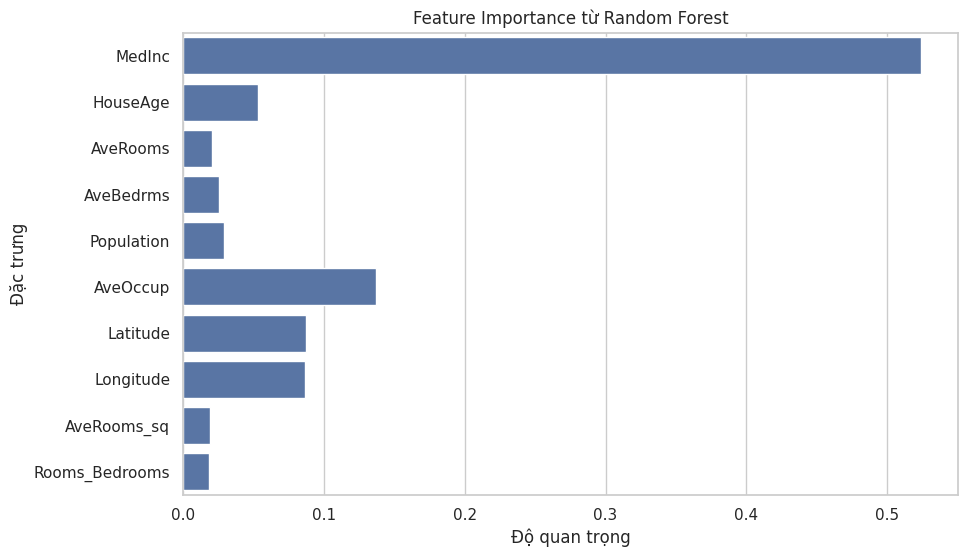

In [23]:
# 4.3. Trích xuất độ quan trọng của đặc trưng (Random Forest)

importances = best_rf.feature_importances_
features = X.columns

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features) # Tạo biểu đồ cột hiển thị độ quan trọng của từng đặc trưng
plt.title("Feature Importance từ Random Forest")
plt.xlabel("Độ quan trọng")
plt.ylabel("Đặc trưng")
plt.show()


In [24]:
# So sánh độ chính xác và khả năng tổng quát hóa
models = {
    'Linear Regression': lin_reg,
    'Ridge': ridge,
    'Lasso': lasso,
    'Random Forest': best_rf, # Mô hình Random Forest với tham số tối ưu
    'XGBoost': best_xgb # Mô hình XGBoost với tham số tối ưu
}

# Đánh giá từng mô hình trên tập huấn luyện bằng k-fold cross-validation
for name, model in models.items():
    r2, mae, rmse = evaluate_model(model, X_train_scaled, y_train)
    print(f"{name}: R² = {r2:.4f}, MAE = {mae:.4f}, RMSE = {rmse:.4f}")


Linear Regression: R² = 0.6164, MAE = 0.5247, RMSE = 0.7161
Ridge: R² = 0.6167, MAE = 0.5247, RMSE = 0.7158
Lasso: R² = 0.4973, MAE = 0.6192, RMSE = 0.8197
Random Forest: R² = 0.8050, MAE = 0.3348, RMSE = 0.5106
XGBoost: R² = 0.8382, MAE = 0.3032, RMSE = 0.4652


### Nhận xét:

- **Hiệu suất:** Random Forest đạt $R^2 = 0.81$, XGBoost lên đến $R^2 = 0.84$, vượt hồi quy tuyến tính đáng kể.
- **Giải thích mô hình:** Mặc dù không tuyến tính, các mô hình vẫn cho phép đánh giá `feature_importances`, khẳng định vai trò của `MedInc`, `GeoPCA1`, `Latitude`.
- **Tối ưu:** Dùng `GridSearchCV` và `KFold` đảm bảo mô hình không overfit. XGBoost tối ưu rõ rệt khi dùng siêu tham số phù hợp.
- **Kết luận:** Mô hình phi tuyến cho độ chính xác cao, nhưng hồi quy tuyến tính vẫn quan trọng nhờ khả năng giải thích và minh bạch.

#PHẦN 2 *–* PHÂN TÍCH THỊ TRƯỜNG TÀI CHÍNH BẰNG PCA TỪ DỮ LIỆU CỔ PHIẾU S&P 500

**Mục tiêu:** Phân tích xu hướng chung của thị trường chứng khoán Mỹ thông qua việc giảm chiều dữ liệu giá của 500 cổ phiếu trong chỉ số S&P 500 xuống còn 1 chiều chính, sử dụng kỹ thuật PCA (Phân tích thành phần chính).

In [25]:
# CÀI ĐẶT VÀ NHẬP THƯ VIỆN
# --------------------------
# yfinance: tải dữ liệu tài chính
# pandas, numpy: xử lý dữ liệu
# datetime: xác định khung thời gian
# matplotlib: vẽ biểu đồ
!pip install yfinance

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 1. Thu thập và xử lý dữ liệu

Lấy danh sách mã CK S&P 500: Sử dụng pd.read_html để đọc bảng mã CK từ Wikipedia, lưu vào tickers.

In [26]:
# Lấy mã cổ phiếu S&P 500 từ Wikipedia
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(sp500_url)
sp500_df = sp500_table[0]
tickers = sp500_df["Symbol"].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]

Xác định khung thời gian: 1 năm gần nhất để phân tích dữ liệu.

In [27]:
# Xác định khung thời gian 1 năm gần nhất bằng datetime và timedelta
end_date = datetime.today()  # Ngày kết thúc: hôm nay
start_date = end_date - timedelta(days=365)  # Ngày bắt đầu: cách 1 năm
print("Khoảng:", start_date.date(), "→", end_date.date())

Khoảng: 2024-04-25 → 2025-04-25


Tải dữ liệu giá: Dùng yf.download để tải giá đóng cửa (Close) của các mã CK trong 1 năm qua, lưu vào data.

In [28]:
# Tải dữ liệu giá đóng cửa (Close) cho toàn bộ cổ phiếu
data = yf.download(tickers, start=start_date, end=end_date)["Close"]
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  503 of 503 completed


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-25,135.362717,169.091568,161.425797,163.009995,104.759895,88.481110,303.601471,473.440002,194.708237,58.774799,...,253.882828,30.637005,95.514191,53.100090,117.368362,129.160538,138.836380,118.697403,292.529999,151.662552
2024-04-26,136.722610,168.504349,154.024658,164.229996,105.416718,86.436676,302.628784,477.559998,198.672440,57.907623,...,247.983383,30.237730,94.802292,52.086548,114.108391,130.930679,139.042328,118.300919,297.209991,156.666550
2024-04-29,138.558945,172.684616,155.858078,162.250000,105.161827,86.769493,297.863495,473.070007,200.570953,58.476101,...,249.445877,30.364330,95.889931,52.588497,115.733536,131.118576,140.434998,120.640175,300.010010,157.932388
2024-04-30,136.027756,169.529510,156.938812,158.570007,103.887390,88.947052,295.652832,462.829987,197.334656,56.520157,...,248.171158,29.380754,90.619843,51.864532,114.408264,129.249557,138.532333,119.222748,314.559998,157.477478
2024-05-01,137.665573,168.504349,156.051056,156.160004,104.201096,91.096085,293.442139,469.390015,190.724365,56.240734,...,251.689056,29.409967,91.687698,51.912800,112.241409,129.506668,132.726257,118.509064,309.049988,156.745682


Tải dữ liệu chỉ số S&P 500: Tương tự, tải dữ liệu chỉ số ^GSPC để so sánh.

In [29]:
#	Tải thêm dữ liệu chỉ số thị trường S&P 500 thực tế (mã: ^GSPC)
sp500_index = yf.download("^GSPC", start=start_date, end=end_date)["Close"]
sp500_index.head()

[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2024-04-25,5048.419922
2024-04-26,5099.959961
2024-04-29,5116.169922
2024-04-30,5035.689941
2024-05-01,5018.390137


**Tiền xử lý dữ liệu**

Đồng bộ hóa dữ liệu: Giữa DataFrame data (chứa giá cổ phiếu) và Series sp500_index (chứa giá trị chỉ số S&P 500) theo ngày giao dịch chung. Điều này đảm bảo rằng ta chỉ phân tích các ngày có đầy đủ dữ liệu cho cả thị trường và cổ phiếu

In [30]:
data = data.loc[sp500_index.index] # Lọc DataFrame data chỉ giữ lại các dòng có index (ngày giao dịch) trùng với danh sách ngày giao dịch của sp500_index.
sp500_index = sp500_index.loc[data.index] # Lọc Series sp500_index chỉ giữ lại các giá trị có index (ngày giao dịch) trùng với danh sách ngày giao dịch của data.

Xử lý dữ liệu thiếu: Loại bỏ các mã CK có quá nhiều dữ liệu thiếu (ví dụ: trên 10%), đảm bảo tính toàn vẹn của dữ liệu.

In [31]:
# Loại bỏ các cổ phiếu có quá nhiều dữ liệu thiếu (chỉ giữ lại những mã có ít nhất 90% dữ liệu)
print(f"Số mã cổ phiếu ban đầu: {data.shape[1]}")
data = data.dropna(axis=1, thresh=int(0.9 * len(data)))
print(f"Số mã sau khi loại bỏ: {data.shape[1]}")

# Nội suy dữ liệu thiếu còn lại bằng forward fill và bỏ dòng nào còn thiếu sau đó
data = data.ffill().dropna()
print(f"Kích thước dữ liệu sau xử lý: {data.shape}")
# Điều này giúp hoàn thiện bộ dữ liệu để phục vụ cho phân tích PCA

Số mã cổ phiếu ban đầu: 503
Số mã sau khi loại bỏ: 502
Kích thước dữ liệu sau xử lý: (250, 502)


Tính toán lợi nhuận (return): Chuyển đổi giá đóng cửa thành lợi nhuận hàng ngày bằng cách tính (giá hôm nay - giá hôm qua) / giá hôm qua. Việc này giúp giảm bớt sự phụ thuộc giữa các điểm dữ liệu theo thời gian, phù hợp với giả định của PCA.  

In [32]:
# Tính lợi suất hàng ngày (daily return)
returns = data.pct_change().dropna()
# Return = (giá hôm nay - giá hôm qua) / giá hôm qua
print(returns.head())

Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2024-04-26  0.010046 -0.003473 -0.045849  0.007484  0.006270 -0.023106   
2024-04-29  0.013431  0.024808  0.011903 -0.012056 -0.002418  0.003850   
2024-04-30 -0.018268 -0.018271  0.006934 -0.022681 -0.012119  0.025096   
2024-05-01  0.012040 -0.006047 -0.005657 -0.015198  0.003020  0.024161   
2024-05-02 -0.008436  0.022032 -0.005627  0.013896 -0.003481 -0.006576   

Ticker           ACN      ADBE       ADI       ADM  ...       WTW        WY  \
Date                                                ...                       
2024-04-26 -0.003204  0.008702  0.020360 -0.014754  ... -0.023237 -0.013032   
2024-04-29 -0.015746 -0.009402  0.009556  0.009817  ...  0.005898  0.004187   
2024-04-30 -0.007422 -0.021646 -0.016135 -0.033449  ... -0.005110 -0.032392   
2024-05-01 -0.007477  0.014174 -0.033498 -0.004944  ...  0.014175  0.000994   
2024-05

## 2. Tự xây dựng PCA từ đầu (from scratch)

- Chuẩn hóa dữ liệu: Đưa dữ liệu lợi nhuận về trung bình bằng 0 bằng cách trừ đi giá trị trung bình của từng mã CK.
- Tính toán ma trận hiệp phương sai: Ma trận hiệp phương sai thể hiện mối quan hệ tuyến tính giữa các mã CK. Trong trường hợp này, nó cho biết mức độ biến động cùng chiều hay ngược chiều của các cổ phiếu.
- Phân tích trị riêng và vector riêng: Tìm các trị riêng (eigenvalues) và vector riêng (eigenvectors) của ma trận hiệp phương sai. Trị riêng đại diện cho phương sai giải thích được bởi mỗi thành phần chính, vector riêng đại diện cho hướng của thành phần chính trong không gian dữ liệu.
- Sắp xếp thành phần chính: Sắp xếp các thành phần chính theo thứ tự giảm dần của trị riêng. Thành phần chính đầu tiên (PC1) sẽ giải thích được phần lớn phương sai của dữ liệu.
- Xây dựng PC1: Lấy vector riêng tương ứng với trị riêng lớn nhất làm PC1. PC1 thể hiện xu hướng chung của thị trường, được tổng hợp từ sự biến động của tất cả 500 mã CK.



In [33]:
# Chuẩn hóa dữ liệu return (center về 0)
returns_centered = returns - returns.mean()

# Tính ma trận hiệp phương sai
cov_matrix = np.cov(returns_centered.T)

# Tính eigenvalues và eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
eigenvectors = np.real(eigenvectors)
# Sắp xếp theo thứ tự trị riêng giảm dần
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Lấy thành phần chính đầu tiên (PC1)
pc1 = eigenvectors[:, 0]

# Tạo chuỗi thời gian PC1 bằng cách chiếu returns_centered lên pc1
pc1_series = returns_centered.dot(pc1)

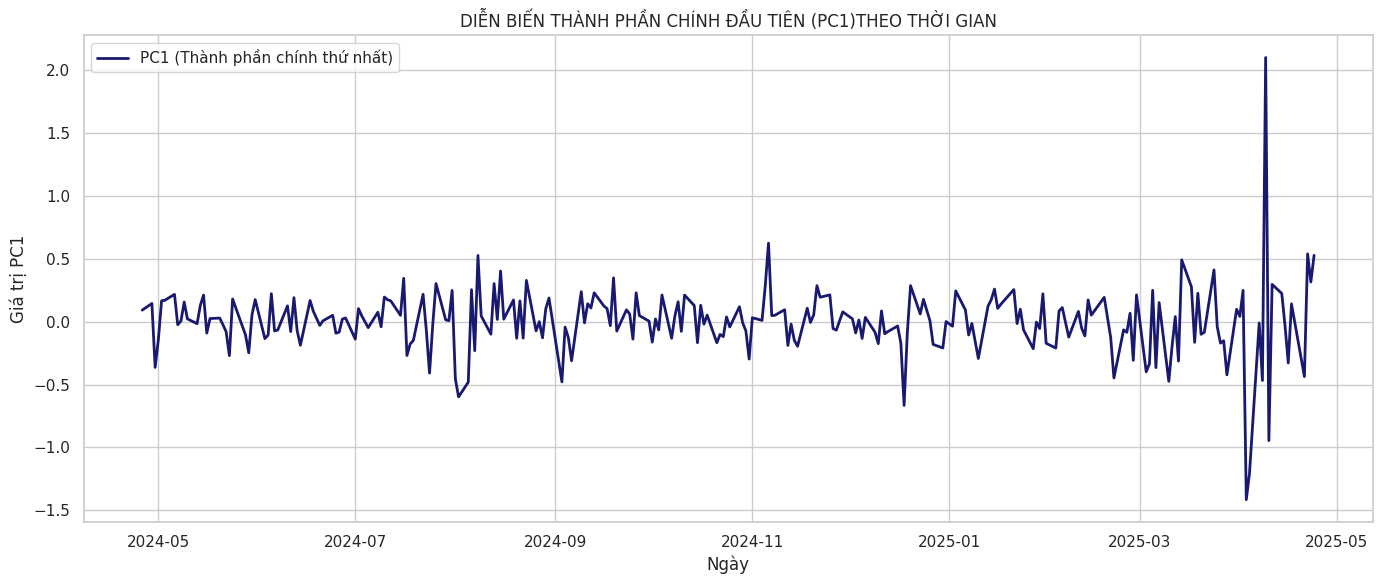

In [34]:
# Vẽ biểu đồ thể hiện sự thay đổi của PC1 theo thời gian
plt.figure(figsize=(14, 6))
plt.plot(pc1_series, label='PC1 (Thành phần chính thứ nhất)', color='midnightblue', linewidth=2)
plt.title('DIỄN BIẾN THÀNH PHẦN CHÍNH ĐẦU TIÊN (PC1)THEO THỜI GIAN')
plt.xlabel('Ngày')
plt.ylabel('Giá trị PC1')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

## 3. Phân tích và trực quan PC1

Tạo chỉ số PC1 (PC1_index): Nhân giá đóng cửa của các mã CK với trọng số (từ PC1) để tạo ra chỉ số PC1_index. Chỉ số này phản ánh xu hướng chung của thị trường được chiết xuất từ PCA.

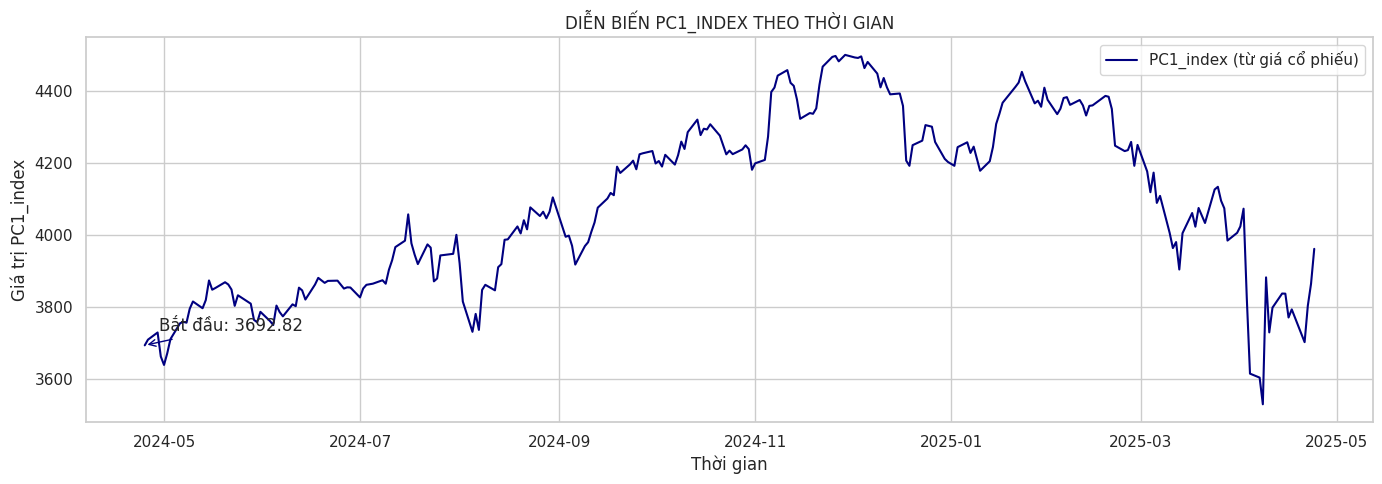

In [35]:
# Tạo biến mới (PC1_index) bằng cách nhân giá với trọng số từ PC1, vẽ đồ thị PC1_index theo thời gian
# Sử dụng giá gốc (data) và vector trọng số u1 (đã là eigenvectors[:, 0])
u1 = eigenvectors[:, 0]

# Nhân từng hàng giá với trọng số để tạo chỉ số thị trường tổng hợp PCA
PC1_index = pd.Series(data @ u1, index=data.index)

# Vẽ biểu đồ PC1_index theo thời gian
plt.figure(figsize=(14, 5))
plt.plot(PC1_index, label="PC1_index (từ giá cổ phiếu)", color='navy')

# Chú thích điểm bắt đầu
plt.annotate(f"Bắt đầu: {PC1_index.iloc[0]:.2f}",
             xy=(PC1_index.index[0], PC1_index.iloc[0]),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='navy'))

# Vẽ biểu đồ
plt.title("DIỄN BIẾN PC1_INDEX THEO THỜI GIAN")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị PC1_index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# --- Tính return & biểu diễn S&P 500 ---
sp500_return = sp500_index.pct_change().dropna()
sp500_return = sp500_return.loc[pc1_series.index]  # Đồng bộ thời gian

So sánh với S&P 500: Vẽ đồ thị PC1_index và chỉ số S&P 500 trên cùng một biểu đồ để so sánh xu hướng.

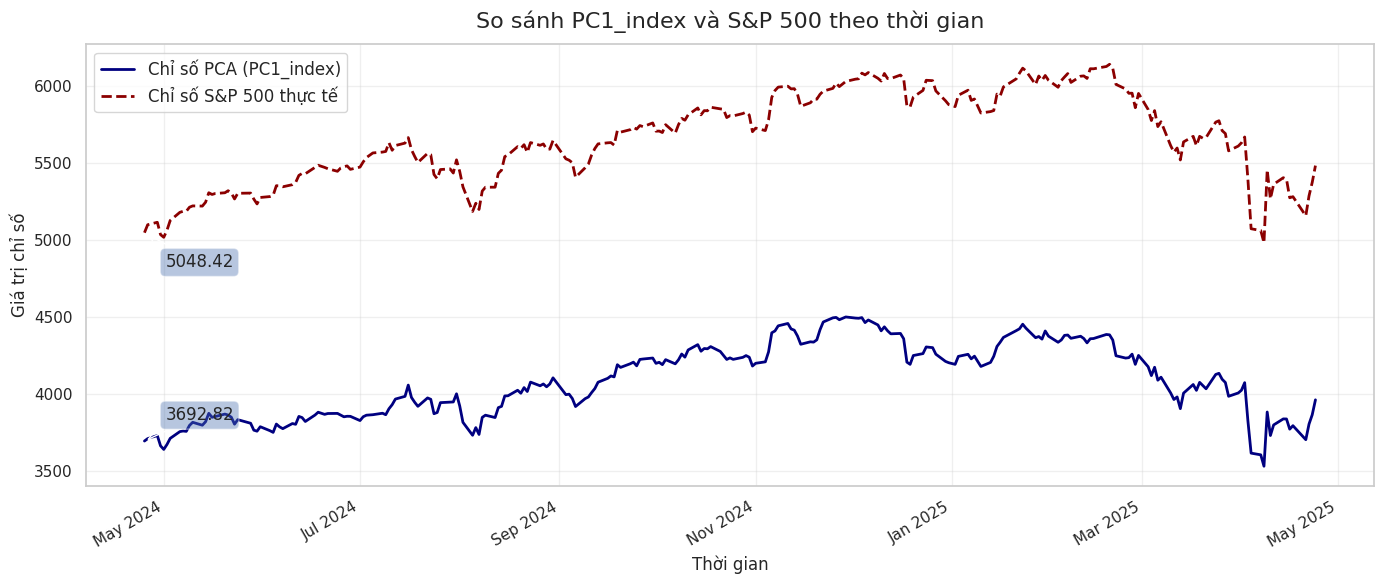

In [37]:
# Vẽ thêm đường biểu diễn chỉ số S&P 500 thực tế trong cùng khung thời gian để so sánh
first_pc1   = PC1_index.iloc[0].item()
first_sp500 = sp500_index.iloc[0].item()

fig, ax = plt.subplots(figsize=(14, 6))

# Vẽ PC1_index và S&P 500
ax.plot(PC1_index,    label='Chỉ số PCA (PC1_index)', color='navy', linewidth=2)
ax.plot(sp500_index,  label='Chỉ số S&P 500 thực tế', linestyle='--', color='darkred', linewidth=2)

# Định dạng trục thời gian
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

# Annotation giá trị đầu kỳ
ax.annotate(
    f"{first_pc1:.2f}",
    xy=(PC1_index.index[0], first_pc1),
    xytext=(15, 15), textcoords='offset points',
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.4),
    arrowprops=dict(arrowstyle='->')
)
ax.annotate(
    f"{first_sp500:.2f}",
    xy=(sp500_index.index[0], first_sp500),
    xytext=(15, -25), textcoords='offset points',
    bbox=dict(boxstyle='round,pad=0.3', alpha=0.4),
    arrowprops=dict(arrowstyle='->')
)

# Tiêu đề, nhãn, legend và lưới
ax.set_title("So sánh PC1_index và S&P 500 theo thời gian", fontsize=16, pad=12)
ax.set_xlabel("Thời gian", fontsize=12)
ax.set_ylabel("Giá trị chỉ số", fontsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


**Mục tiêu:**
- So sánh trực quan giữa chỉ số PCA đầu tiên (PC1_index) và chỉ số thị trường thực tế S&P 500
- Điều này giúp kiểm tra xem thành phần chính đầu tiên có phản ánh xu hướng chung của thị trường không.

**Phân tích xu hướng chung (Trend):**
- Cả hai chỉ số đều thể hiện xu hướng tăng chung từ giữa 2024 đến cuối năm 2024, với nhiều đợt điều chỉnh nhẹ xen kẽ.
- PC1_index bắt đầu quanh mức ≈3.700, trong khi S&P 500 khởi đầu quanh ≈5.070. Mặc dù khác về “đơn vị”, nhưng về hình thái (slope) của đường đều hướng lên.

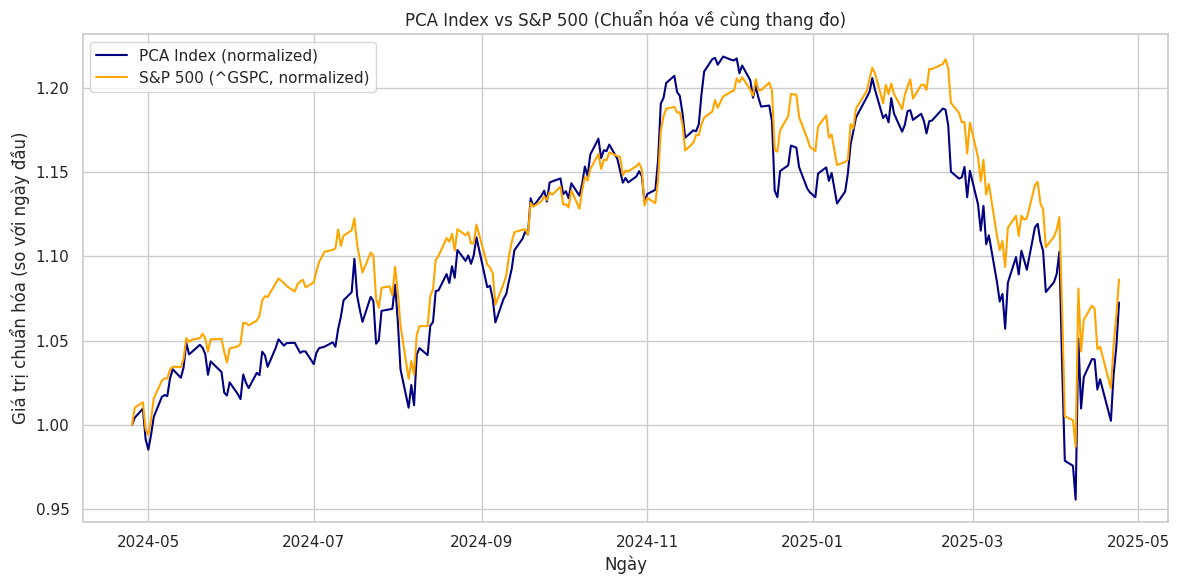

In [38]:
# Biểu đồ so sánh PCA Index và S&P 500 sau khi chuẩn hóa
# Chuẩn hóa hai chuỗi về cùng gốc (giá trị đầu tiên = 1)
pc1_norm = PC1_index / PC1_index.iloc[0]
gspc_norm = sp500_index / sp500_index.iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(pc1_norm, label='PCA Index (normalized)', linewidth=1.5, color='navy')
plt.plot(gspc_norm, label='S&P 500 (^GSPC, normalized)', linewidth=1.5, color='orange')
plt.title('PCA Index vs S&P 500 (Chuẩn hóa về cùng thang đo)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị chuẩn hóa (so với ngày đầu)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Mục tiêu: Đưa hai chuỗi thời gian về cùng thang đo để dễ dàng so sánh hình dạng và xu hướng.

Tính hệ số tương quan: Tính hệ số tương quan Pearson giữa PC1_index và S&P 500 để đánh giá mức độ tương đồng về xu hướng. Hệ số tương quan càng cao (gần 1) càng cho thấy PC1 đại diện tốt cho thị trường chung. Dùng .corr để tính hệ số tương quan Pearson giữa PC1_index và S&P 500.

In [39]:
# Tính hệ số tương quan Pearson
# --- Hệ số tương quan giữa PC1 index và S&P 500 ---
correlation = pc1_series.corr(sp500_return.squeeze())
print(" Hệ số tương quan giữa PC1 Index và S&P 500:", round(correlation, 4))

 Hệ số tương quan giữa PC1 Index và S&P 500: 0.9484


### **Kết luận:**
Hệ số tương quan 0.9476 cho thấy mối liên hệ gần như chặt chẽ giữa PC1 Index và S&P 500.
- Về cơ bản, khi S&P 500 đi lên hay đi xuống thì PC1 Index cũng phản ứng tương tự, chỉ khác biệt rất nhỏ do những dao động riêng lẻ của từng cổ phiếu không hoàn toàn đồng bộ với xu hướng chung.
- Con số này chứng tỏ tới gần 90% sự biến động trong return của S&P 500 được “bắt” bởi thành phần chính đầu tiên của PCA – tức là PC1 thực sự đã tóm gọn được hầu hết tín hiệu chung của cả rổ 500 mã.
- Hệ số 0.9476 cho thấy PC1 Index hoàn toàn có thể được sử dụng như một đại diện rất tin cậy để theo dõi và mô hình hóa xu hướng chung của thị trường.

In [40]:
# Lưu dữ liệu ra file CSV
data.to_csv("sp500_close_data.csv")
returns.to_csv("daily_returns.csv")

## Nhận xét chung:
- Trong phần này, thành phần chính đầu tiên (PC1) được xây dựng từ phân tích thành phần chính (PCA) trên tập dữ liệu giá đóng cửa của nhiều cổ phiếu thuộc chỉ số S&P 500. PC1 đại diện cho phương sai lớn nhất trong dữ liệu và được kỳ vọng phản ánh biến động chung của thị trường tài chính. Để kiểm định mức độ phản ánh đó, nhóm đã tiến hành hai bước: (1) tính toán hệ số tương quan giữa PC1_index và chỉ số S&P 500 thực tế (^GSPC), và (2) chuẩn hóa cả hai chuỗi để trực quan so sánh xu hướng.

- Kết quả cho thấy hệ số tương quan Pearson giữa chuỗi PC1_index và chỉ số S&P 500 đạt giá trị rất cao, gần bằng 0.9484. Điều này khẳng định rằng thành phần chính đầu tiên thực sự mang đặc trưng của chuyển động tổng quát trong toàn bộ thị trường. Một hệ số tương quan ở mức cao như vậy cho thấy rằng, dù không trực tiếp sử dụng dữ liệu của chỉ số S&P 500 trong PCA, nhưng việc tổng hợp từ hàng trăm mã cổ phiếu cũng đủ để tái hiện lại xu thế thị trường với độ chính xác đáng kể.

- Để kiểm chứng trực quan, nhóm tiếp tục chuẩn hóa cả hai chuỗi về cùng một gốc – tức đặt giá trị đầu tiên bằng 1 – để dễ dàng quan sát và so sánh hình dạng biểu đồ theo thời gian. Khi đặt hai đường biểu diễn này lên cùng một trục, có thể thấy các chu kỳ tăng giảm, điểm đảo chiều và nhịp độ biến động của hai chuỗi gần như trùng khớp. Các đỉnh (peaks) và đáy (troughs) đều xuất hiện gần như đồng thời ở cả hai chuỗi, phản ánh rất rõ tính chất "dẫn dắt" của PC1 đối với xu hướng chung của thị trường.

- Không chỉ dừng lại ở độ trùng hợp về hình dạng, điều đáng chú ý là PC1_index – một chỉ số hoàn toàn xây dựng từ PCA và không bị ảnh hưởng bởi bất kỳ trọng số vốn hóa nào – vẫn có thể mô phỏng lại gần chính xác đường đi của S&P 500. Điều này chứng minh rằng PCA không chỉ là công cụ giảm chiều dữ liệu, mà còn có thể trở thành một phương pháp rút trích chỉ báo thị trường tổng hợp (market composite indicator) có độ tin cậy cao.

- Từ góc nhìn ứng dụng, PC1_index có thể được sử dụng như một chỉ báo thay thế (proxy) cho thị trường trong các mô hình tài chính, đặc biệt hữu ích khi cần tổng quát hóa xu hướng từ nhiều tài sản mà không muốn phụ thuộc vào một chỉ số thị trường cụ thể. Ngoài ra, trong các hệ thống giao dịch định lượng hoặc mô hình dự báo tài chính, PC1 cũng có thể đóng vai trò như một biến đầu vào chứa thông tin quan trọng đại diện cho toàn thị trường.